## Modelar volatilidad del retorno de BTC usando GARCH

Modelar la volatilidad del retorno de BTC, donde se conoce que la varianza no es constante (heterocedasticidad).

In [1]:
!pip install arch

   ---------------------------------------- 0.0/927.1 kB ? eta -:--:--
   ---------------------------------------- 10.2/927.1 kB ? eta -:--:--
   --- ------------------------------------ 71.7/927.1 kB 1.3 MB/s eta 0:00:01
   --------------------- ------------------ 491.5/927.1 kB 5.1 MB/s eta 0:00:01
   ---------------------------------------- 927.1/927.1 kB 7.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error

In [4]:
df = pd.read_csv("../datasets/merged/master_improved.csv", parse_dates=["Unnamed: 0"])
df = df.rename(columns={"Unnamed: 0": "Date"}).set_index("Date")

/Users/cbarril/dev/posgrado/tp_ast1_19co2024/ast1/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0013. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


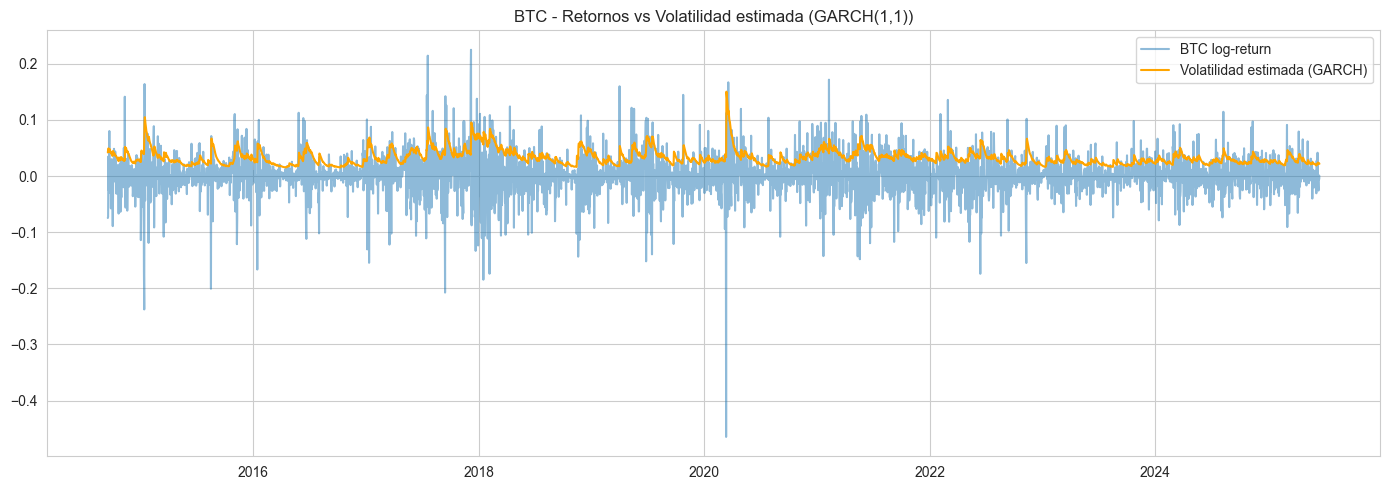

                       Zero Mean - GARCH Model Results                        
Dep. Variable:         btc_log_return   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                7774.02
Distribution:                  Normal   AIC:                          -15542.0
Method:            Maximum Likelihood   BIC:                          -15523.2
                                        No. Observations:                 3924
Date:                Mon, Jun 16 2025   Df Residuals:                     3924
Time:                        23:23:17   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      2.6029e-05  2.013e-06     12.933  2.939e-38 [2.

In [5]:
btc_ret = df["btc_log_return"].dropna()

# Intento de ajustar modelo GARCH(1,1) con media zero porque estoy usando los log retornos
garch_model = arch_model(btc_ret, vol='GARCH', p=1, q=1, mean='Zero')
garch_fit = garch_model.fit(disp="off")

conditional_vol = garch_fit.conditional_volatility

fig, ax1 = plt.subplots(figsize=(14, 5))
ax1.plot(btc_ret.index, btc_ret, label="BTC log-return", alpha=0.5)
ax1.plot(conditional_vol.index, conditional_vol, color="orange", label="Volatilidad estimada (GARCH)")
ax1.set_title("BTC - Retornos vs Volatilidad estimada (GARCH(1,1))")
ax1.legend()
plt.tight_layout()
plt.show()

print(garch_fit.summary())

La serie *btc_log_return* tiene valores muy pequeños (~0.0013 de media). Esto es esperable porque los log-retornos suelen estar centrados cerca de 0 y tienen poca magnitud.

Como el modelo converge bien (como en este caso), se ignorará dicho Warning. Alternativamente se podrían multiplicar los retornos por 100 o 1000 antes de ajustar, como sugiere el output.


### Conclusiones

- alpha[1] + beta[1] = 0.98 → muy cerca de 1, por lo tanto el proceso GARCH es altamente persistente.

- Los shocks afectan mucho y lentamente se disipan: típico de mercados especulativos como BTC.

- El modelo se ajustó correctamente (todos los coeficientes son significativos: p < 0.05).

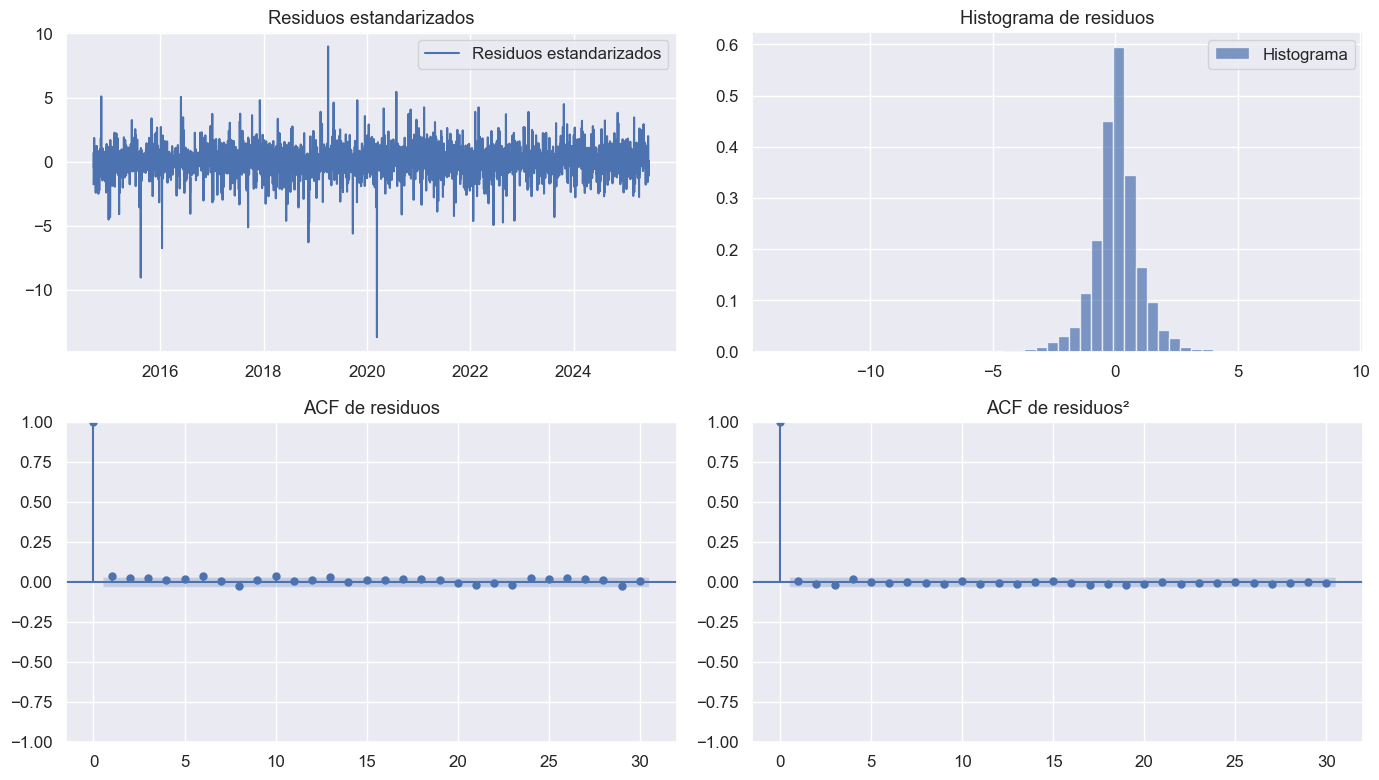

In [11]:
# Residuos estandarizados
residuals = garch_fit.std_resid.dropna()

fig, axs = plt.subplots(2, 2, figsize=(14, 8))

axs[0, 0].plot(residuals, label="Residuos estandarizados")
axs[0, 0].set_title("Residuos estandarizados")
axs[0, 0].legend()

axs[0, 1].hist(residuals, bins=50, density=True, alpha=0.7, label="Histograma")
axs[0, 1].set_title("Histograma de residuos")
axs[0, 1].legend()

plot_acf(residuals, ax=axs[1, 0], lags=30)
axs[1, 0].set_title("ACF de residuos")

plot_acf(residuals**2, ax=axs[1, 1], lags=30)
axs[1, 1].set_title("ACF de residuos²")

plt.tight_layout()
plt.show()

1. Los residuos estandarizados se ven como una serie centrada en torno a 0, sin tendencia clara. La dispersión parece más o menos estable en el tiempo (sin nuevos clústeres de volatilidad no modelados). Hay algunos outliers grandes, pero es esperable en criptomonedas como BTC. En conclusión, los residuos parecen ruido blanco, sin patrones estructurales residuales.

2. Distribución simétrica y centrada en 0, como se esperaría. Un más pico y con colas más largas que la normal. Tal vez se podrían modelar mejor con una distribución t si se quiere capturar mejor las colas.

3. Solo el lag 0 es significativo, como se esperaba. Todos los demás lags parecen estar dentro del área de confianza, y por lo tanto no hay autocorrelación. El modelo parece haber capturado bien la dinámica de los retornos. Que los residuos no están correlacionados quiere decir que no quedó estructura sin modelar.

4. Mismo resultado; solo el lag 0 es significativo. No hay autocorrelación en los residuos al cuadrado, por lo tanto la heterocedasticidad fue absorbida por el GARCH.


In [16]:
print("Test de Ljung-Box sobre residuos:")
ljung_resid = acorr_ljungbox(residuals, lags=[10, 20, 30], return_df=True)
print(ljung_resid)

print("Test de Ljung-Box sobre residuos²:")
ljung_sq = acorr_ljungbox(residuals**2, lags=[10, 20, 30], return_df=True)
print(ljung_sq)

Test de Ljung-Box sobre residuos:
      lb_stat  lb_pvalue
10  26.543522   0.003074
20  35.341358   0.018360
30  48.332524   0.018362
Test de Ljung-Box sobre residuos²:
      lb_stat  lb_pvalue
10   4.574911   0.917709
20   9.684838   0.973533
30  11.613631   0.998978



Según el test, los residuos sí tienen autocorrelación significativa y por lo tanto el modelo no capturó completamente la dinámica de los retornos. Esto puede significar que:

- Un GARCH(1,1) es muy simple.

- Quizás falta un componente AR en la media.

- O hay lags relevantes en la media que no se incluyeron (porque se usó mean="Zero").

Se prueba entonces ahora un modelo GARCH(1,1) con media AR(1) para permitirle al modelo capturar autocorrelaciones en la media, que el test de Ljung–Box dió a conocer.

In [23]:
btc_ret = df["btc_log_return"].dropna()

model_ar1 = arch_model(btc_ret, vol='GARCH', p=1, q=1, mean='AR', lags=1)
result_ar1 = model_ar1.fit(disp='off')

print(result_ar1.summary())

residuals_ar1 = result_ar1.std_resid.dropna()

                           AR - GARCH Model Results                           
Dep. Variable:         btc_log_return   R-squared:                       0.000
Mean Model:                        AR   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                7779.84
Distribution:                  Normal   AIC:                          -15549.7
Method:            Maximum Likelihood   BIC:                          -15518.3
                                        No. Observations:                 3923
Date:                Mon, Jun 16 2025   Df Residuals:                     3921
Time:                        14:50:12   Df Model:                            2
                                   Mean Model                                   
                    coef    std err          t      P>|t|       95.0% Conf. Int.
--------------------------------------------------------------------------------
Const         1.7908e-03  5.997e-04      2.986

c:\Users\Ramiro\anaconda3\envs\maestria\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001298. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [18]:
print("Test de Ljung-Box sobre residuos:")
ljung_resid_ar1 = acorr_ljungbox(residuals_ar1, lags=[10, 20, 30], return_df=True)
print(ljung_resid_ar1)

print("Test de Ljung-Box sobre residuos²:")
ljung_sq_ar1 = acorr_ljungbox(residuals_ar1**2, lags=[10, 20, 30], return_df=True)
print(ljung_sq_ar1)

Test de Ljung-Box sobre residuos:
      lb_stat  lb_pvalue
10  33.457310   0.000228
20  42.151529   0.002643
30  55.717094   0.002942
Test de Ljung-Box sobre residuos²:
      lb_stat  lb_pvalue
10   4.811604   0.903402
20  10.110288   0.966128
30  12.091167   0.998495


Nuevamente, los residuos sí tienen autocorrelación significativa y por lo tanto el modelo no capturó completamente la dinámica de los retornos. Se prueba a continuación con un AR(2) en la media.

In [25]:
btc_ret = df["btc_log_return"].dropna()

model_ar2 = arch_model(btc_ret, mean="AR", lags=2, vol="GARCH", p=1, q=1)
result_ar2 = model_ar2.fit(disp='off')

print(result_ar2.summary())

residuals_ar2 = result_ar2.std_resid.dropna()

                           AR - GARCH Model Results                           
Dep. Variable:         btc_log_return   R-squared:                       0.001
Mean Model:                        AR   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                7779.60
Distribution:                  Normal   AIC:                          -15547.2
Method:            Maximum Likelihood   BIC:                          -15509.5
                                        No. Observations:                 3922
Date:                Mon, Jun 16 2025   Df Residuals:                     3919
Time:                        14:50:49   Df Model:                            3
                                   Mean Model                                   
                    coef    std err          t      P>|t|       95.0% Conf. Int.
--------------------------------------------------------------------------------
Const         1.8005e-03  6.009e-04      2.996

c:\Users\Ramiro\anaconda3\envs\maestria\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001296. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [26]:
print("Test de Ljung-Box sobre residuos:")
ljung_resid_ar2 = acorr_ljungbox(residuals_ar2, lags=[10, 20, 30], return_df=True)
print(ljung_resid_ar2)

print("Test de Ljung-Box sobre residuos²:")
ljung_sq_ar2 = acorr_ljungbox(residuals_ar2**2, lags=[10, 20, 30], return_df=True)
print(ljung_resid_ar2)

Test de Ljung-Box sobre residuos:
      lb_stat  lb_pvalue
10  31.665020   0.000455
20  40.172820   0.004750
30  53.655063   0.005022
Test de Ljung-Box sobre residuos²:
      lb_stat  lb_pvalue
10  31.665020   0.000455
20  40.172820   0.004750
30  53.655063   0.005022


Empeoró con respecto a la situación anterior. Se probará entonces un modelo ARMA(1,1) + GARCH(1,1).

In [29]:
# Se crea el término exógeno para simular la parte MA(1)
btc_ret = df["btc_log_return"]
ma_component = btc_ret.shift(1)

# Se concatena y elimina filas con NaNs
data = pd.concat([btc_ret, ma_component], axis=1).dropna()
data.columns = ["y", "ma1"]

# Se ajusta modelo ARX(1) + GARCH(1,1) con ma1 como exógeno
model = arch_model(data["y"], mean="ARX", lags=[1], vol="GARCH", p=1, q=1, dist="normal", x=data[["ma1"]])
arma_garch_fit = model.fit(disp="off")

print(arma_garch_fit.summary())

residuals_arma = arma_garch_fit.std_resid.dropna()

                          AR-X - GARCH Model Results                          
Dep. Variable:                      y   R-squared:                       0.001
Mean Model:                      AR-X   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                7779.10
Distribution:                  Normal   AIC:                          -15546.2
Method:            Maximum Likelihood   BIC:                          -15508.6
                                        No. Observations:                 3922
Date:                Mon, Jun 16 2025   Df Residuals:                     3919
Time:                        14:59:30   Df Model:                            3
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
Const      1.6923e-03  5.758e-04      2.939  3.290e-03 

c:\Users\Ramiro\anaconda3\envs\maestria\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001297. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [30]:
print("Test de Ljung-Box sobre residuos:")
ljung_resid_arma = acorr_ljungbox(residuals_arma, lags=[10, 20, 30], return_df=True)
print(ljung_resid_arma)

print("Test de Ljung-Box sobre residuos²:")
ljung_sq_arma = acorr_ljungbox(residuals_arma**2, lags=[10, 20, 30], return_df=True)
print(ljung_sq_arma)

Test de Ljung-Box sobre residuos:
      lb_stat  lb_pvalue
10  33.047699   0.000267
20  41.696714   0.003028
30  55.164024   0.003401
Test de Ljung-Box sobre residuos²:
      lb_stat  lb_pvalue
10   4.791283   0.904677
20  10.057709   0.967113
30  12.032247   0.998563


Se vuelve al modelo AR(1) + GARCH(1,1) que ya tenía buena modelización de la varianza, y se prueba cambiar la distribución de errores a t-student en un intento de capturar colas pesadas para ver si mejoran los tests.

In [33]:
btc_ret = df["btc_log_return"].dropna()

model_ar1_t = arch_model(btc_ret, mean="AR", lags=1, vol="GARCH", p=1, q=1, dist="t")
result_ar1_t = model_ar1_t.fit(disp='off')

print(result_ar1_t.summary())

residuals_ar1_t = result_ar1_t.std_resid.dropna()

                              AR - GARCH Model Results                              
Dep. Variable:               btc_log_return   R-squared:                       0.001
Mean Model:                              AR   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                8275.00
Distribution:      Standardized Student's t   AIC:                          -16538.0
Method:                  Maximum Likelihood   BIC:                          -16500.4
                                              No. Observations:                 3923
Date:                      Mon, Jun 16 2025   Df Residuals:                     3921
Time:                              15:04:20   Df Model:                            2
                                   Mean Model                                   
                    coef    std err          t      P>|t|       95.0% Conf. Int.
-------------------------------------------------------------------------

c:\Users\Ramiro\anaconda3\envs\maestria\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001298. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [34]:
print("Test de Ljung-Box sobre residuos:")
ljung_resid_ar1_t = acorr_ljungbox(residuals_ar1_t, lags=[10, 20, 30], return_df=True)
print(ljung_resid_ar1_t)

print("Test de Ljung-Box sobre residuos²:")
ljung_sq_ar1_t = acorr_ljungbox(residuals_ar1_t**2, lags=[10, 20, 30], return_df=True)
print(ljung_sq_ar1_t)

Test de Ljung-Box sobre residuos:
      lb_stat  lb_pvalue
10  33.450394   0.000229
20  42.210067   0.002596
30  55.748350   0.002918
Test de Ljung-Box sobre residuos²:
      lb_stat  lb_pvalue
10   4.785253   0.905054
20  10.075894   0.966775
30  12.060031   0.998531


Un modelo GARCH(1,1) es adecuado para capturar la volatilidad condicional de los retornos de BTC, pero no logra explicar completamente la dinámica de la media. A pesar de probar AR(1), AR(2) y ARMA(1,1), persiste la autocorrelación en los residuos. Esto sugiere que podría requerirse un modelo más complejo, no lineal o de régimen cambiante para la media, o aceptar que el modelo actual describe solo parcialmente la dinámica del proceso.

Finalmente, con lo investigado hasta el momento, utilizamos el modelo GARCH para predecir la volatilidad de BTC, comparar con la conocida, y confirmar las esperadas limitaciones del mismo:

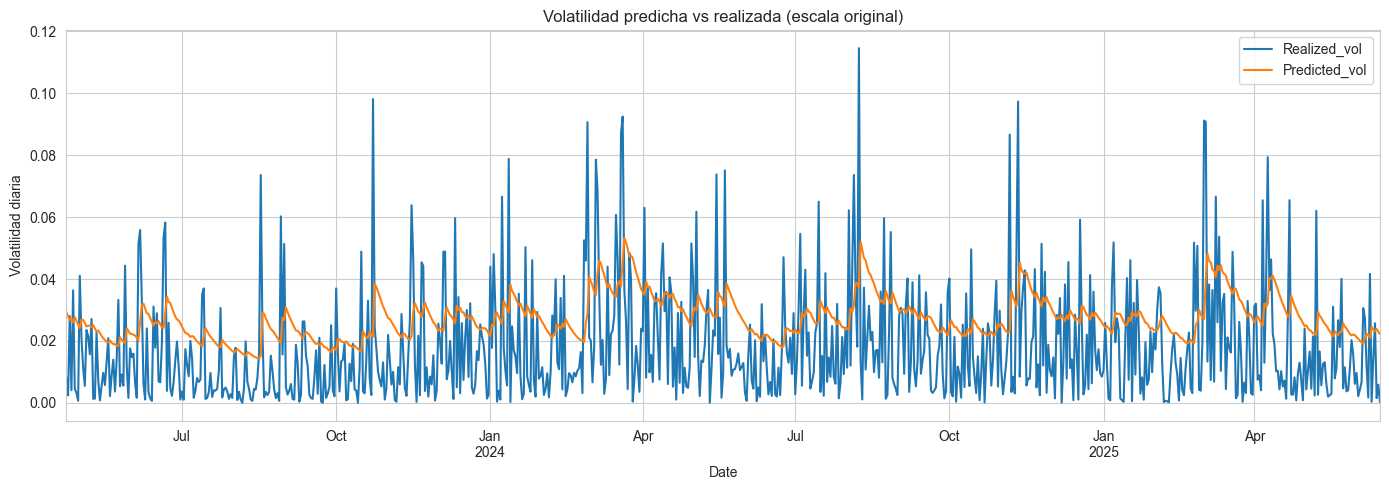

📉 RMSE (escala %): 2.05195
📉 RMSE (escala original): 0.02052


In [15]:
# --- 1. Reescalar retornos -----------------------------
btc_ret_scaled = btc_ret * 100        # escala en porcentajes

# --- 2. Split 80/20 -----------------------------------
split = int(len(btc_ret_scaled) * 0.8)
train_ret = btc_ret_scaled[:split]
test_ret  = btc_ret_scaled[split:]

# --- 3. Rolling‑forecast (re‑estimando cada paso) -------
predicted_vol = []
rolling_window = train_ret.copy()

for date in test_ret.index:
    model = arch_model(rolling_window, vol="GARCH", p=1, q=1, mean="Zero", dist="t")
    fit = model.fit(disp="off")
    sigma = fit.forecast(horizon=1).variance.iloc[-1, 0]**0.5
    predicted_vol.append((date, sigma))

    # agregar el retorno *escalado* real al set de entrenamiento
    rolling_window.loc[date] = test_ret.loc[date]

pred_vol = (pd.DataFrame(predicted_vol, columns=["Date", "Predicted_vol"])
              .set_index("Date"))

# --- 4. Comparar contra volatilidad realizada -----------
realized_vol = test_ret.abs()           # |retorno| es proxy de σ_real

comparison = pd.concat([realized_vol.rename("Realized_vol"),
                        pred_vol["Predicted_vol"]], axis=1).dropna()

# --- 5. Volver a escala original solo para graficar -----
comparison_orig = comparison / 100      # divide por 100 si querés %
comparison_orig.plot(figsize=(14,5),
                     title="Volatilidad predicha vs realizada (escala original)")
plt.ylabel("Volatilidad diaria"); plt.tight_layout(); plt.show()

# --- 6. Métrica de error en la MISMA escala -------------
rmse_scaled = np.sqrt(mean_squared_error(comparison["Realized_vol"], comparison["Predicted_vol"]))
print(f"📉 RMSE (escala %): {rmse_scaled:.5f}")
print(f"📉 RMSE (escala original): {rmse_scaled/100:.5f}")